In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from dataset import *

/home/alecx/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


# Helper functions and variable definitions

In [2]:
activations = ["relu", "elu", "gelu", "leaky-relu", "quadratic"]
data_types = ["usps", "cifar10"]

In [3]:
activations_save = {
    "relu": "ReLU",
    "elu": "ELU",
    "gelu": "GELU",
    "leaky-relu": "Leaky ReLU",
    "quadratic": "Quadratic"
}

data_types_save = {
    "usps": "USPS",
    "cifar10": "CIFAR-10"
}

# Plot training and test accuracies vs. width

## Accuracy vs. width for different activation functions

In [65]:
widths = [16, 32, 64, 128, 256, 512, 1024, 2048]
K = 2
d = 64

# Load in saved results
train_accs_act = np.zeros((len(widths), len(activations)))
test_accs_act = np.zeros((len(widths), len(activations)))

for (i, width) in enumerate(widths):
    for (j, activation) in enumerate(activations):
        results_dir = "save/hybrid/usps/width_" + str(width) + "_depth_2_nonlinear_depth_1_gaussian_init_usps_data_dim_" + str(d) + "_" + str(K) + "_classes_" + activation + "_activation_seed_0"
        train_best_result = torch.load(os.path.join(results_dir, "best.pth"), map_location=torch.device('cpu'))
        test_result = torch.load(os.path.join(results_dir, "test.pth"), map_location=torch.device('cpu'))
        
        cur_train_accs = train_best_result['train_accuracies']
        train_accs_act[i, j] = cur_train_accs[-1]
        
        test_accs_act[i, j] = test_result['test_accuracy']

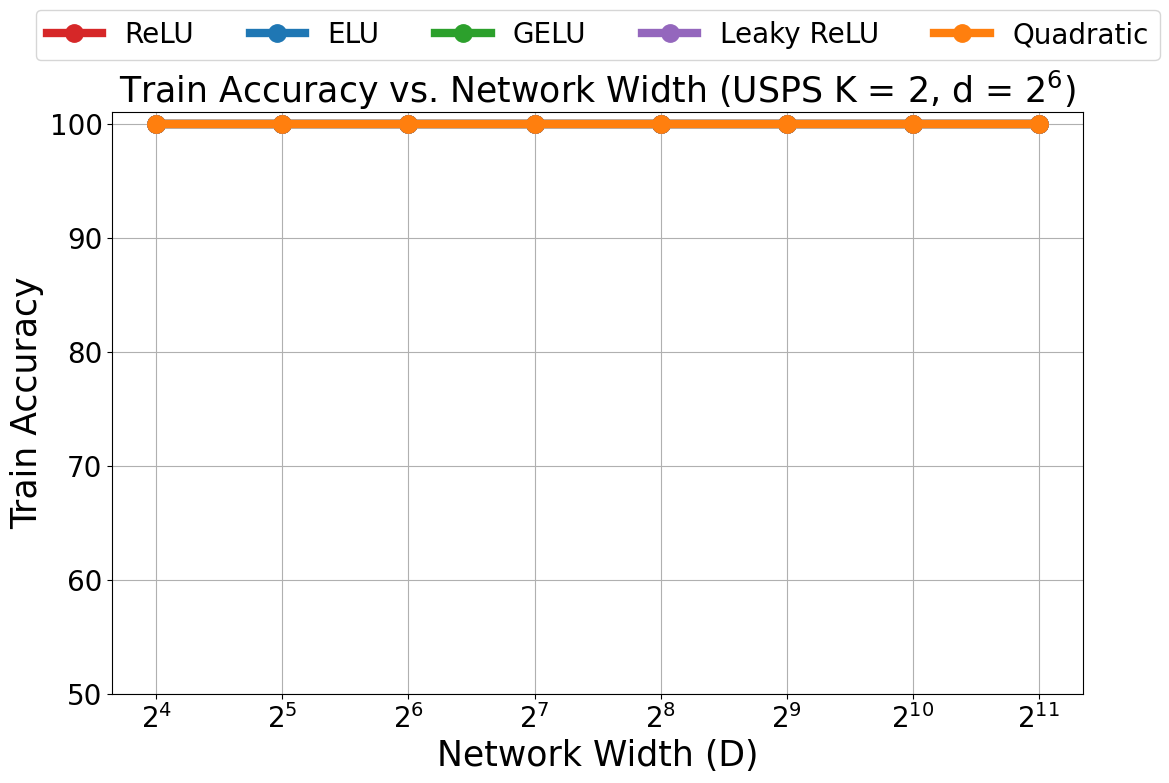

In [66]:
# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))

start_idx = 1
lw = 6
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange'] 
ax1.set_xlabel(r'Network Width (D)', fontsize=25)
ax1.set_ylabel('Train Accuracy', fontsize=25)
ax1.set_title('Train Accuracy vs. Network Width (USPS K = ' + str(K) + ', d = $2^6$)', fontsize=25)

lns = []
for i in range(len(colors)):
    l_i = ax1.plot(widths, list(train_accs_act[:, i]), color=colors[i], linewidth=lw, marker=".", markersize=25,
                  label=activations_save[activations[i]])
    lns += l_i

ax1.set_xscale('log', base=2)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
#lns = l2+l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), fontsize=20, ncol=5)
plt.grid()
ax1.set_ylim(50, 101)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()

plt.savefig('./figures/usps/usps_' + str(K) + '_classes_dim_' + str(d) + '_train.png')

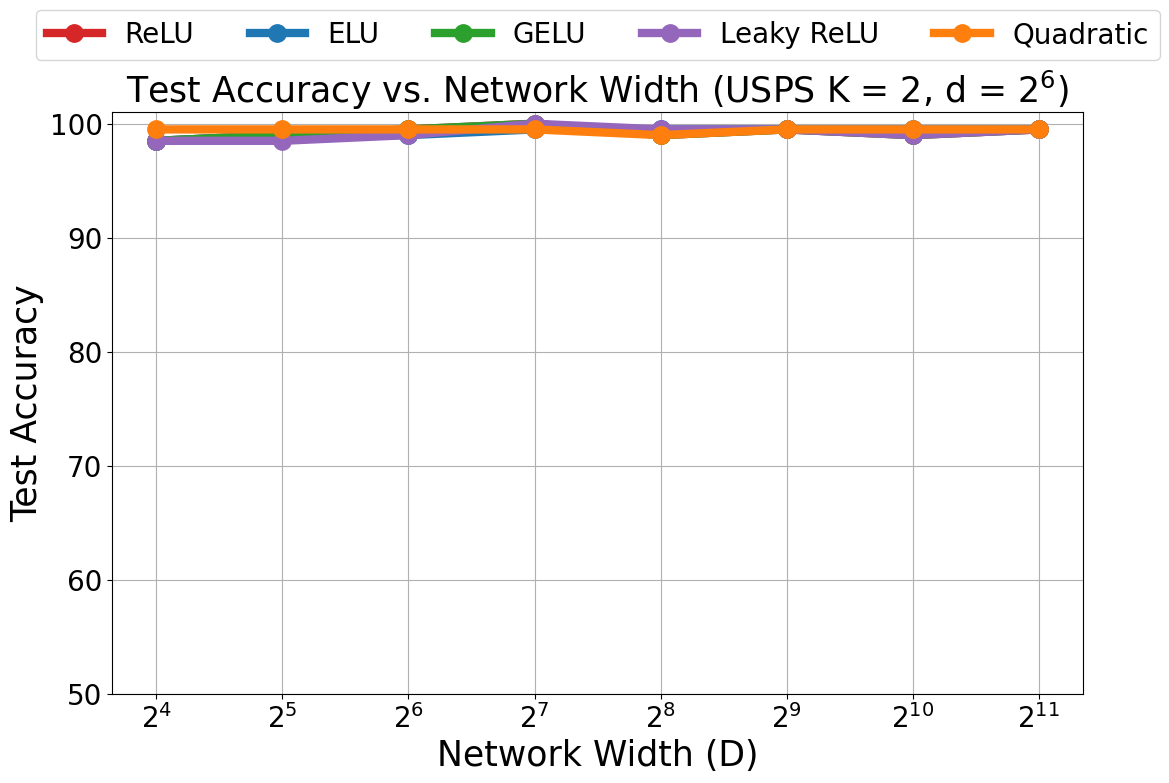

In [67]:
# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))

start_idx = 1
lw = 6
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange'] 
ax1.set_xlabel(r'Network Width (D)', fontsize=25)
ax1.set_ylabel('Test Accuracy', fontsize=25)
ax1.set_title('Test Accuracy vs. Network Width (USPS K = ' + str(K) + ', d = $2^6$)', fontsize=25)

lns = []
for i in range(len(colors)):
    l_i = ax1.plot(widths, list(test_accs_act[:, i]), color=colors[i], linewidth=lw, marker=".", markersize=25,
                  label=activations_save[activations[i]])
    lns += l_i

ax1.set_xscale('log', base=2)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
#lns = l2+l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), fontsize=20, ncol=5)
plt.grid()
ax1.set_ylim(50, 101)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()

plt.savefig('./figures/usps/usps_' + str(K) + '_classes_dim_' + str(d) + '_test.png')

In [47]:
widths = [32, 64, 128, 256, 512, 1024, 2048, 4096]
K = 10

# Load in saved results
train_accs_act = np.zeros((len(widths), len(activations)))
test_accs_act = np.zeros((len(widths), len(activations)))

for (i, width) in enumerate(widths):
    for (j, activation) in enumerate(activations):
        results_dir = "save/hybrid/cifar10/width_" + str(width) + "_depth_2_nonlinear_depth_1_gaussian_init_cifar10_data_" + str(K) + "_classes_" + activation + "_activation_seed_0"
        train_best_result = torch.load(os.path.join(results_dir, "best.pth"), map_location=torch.device('cpu'))
        test_result = torch.load(os.path.join(results_dir, "test.pth"), map_location=torch.device('cpu'))
        
        cur_train_accs = train_best_result['train_accuracies']
        train_accs_act[i, j] = cur_train_accs[-1]
        
        test_accs_act[i, j] = test_result['test_accuracy']

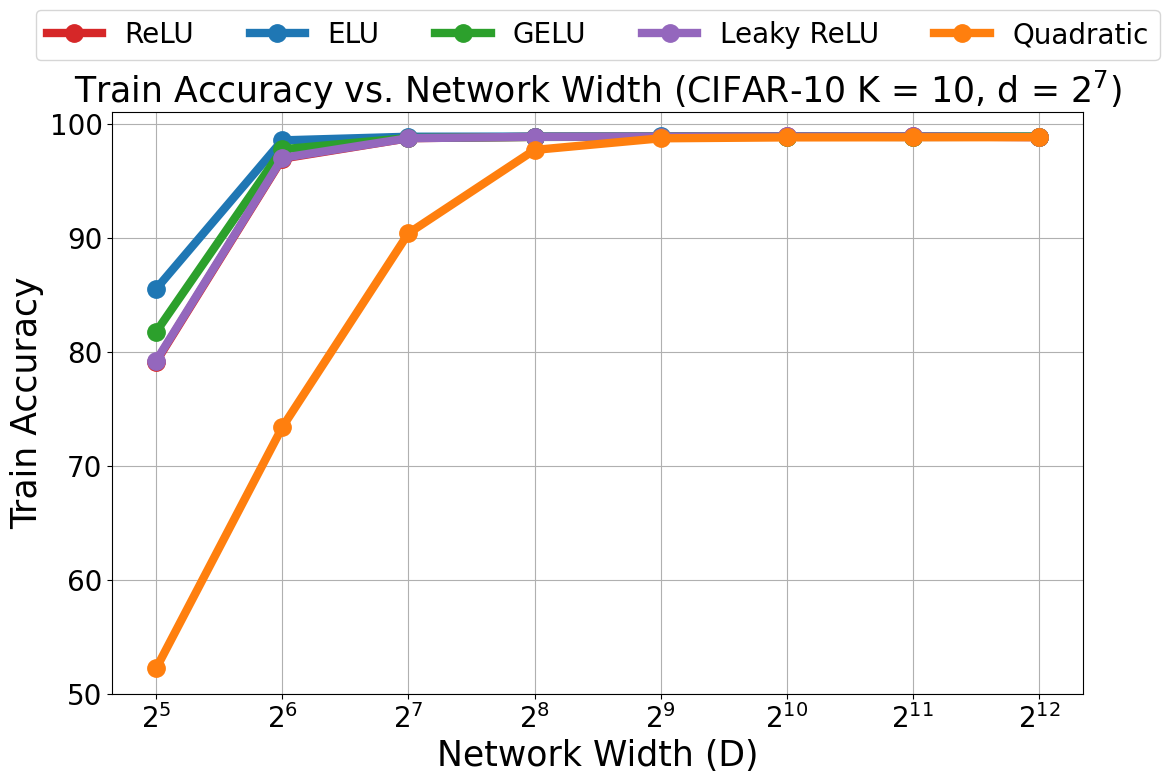

In [48]:
# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))

start_idx = 1
lw = 6
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange'] 
ax1.set_xlabel(r'Network Width (D)', fontsize=25)
ax1.set_ylabel('Train Accuracy', fontsize=25)
ax1.set_title('Train Accuracy vs. Network Width (CIFAR-10 K = ' + str(K) + ', d = $2^7$)', fontsize=25)

lns = []
for i in range(len(colors)):
    l_i = ax1.plot(widths, list(train_accs_act[:, i]), color=colors[i], linewidth=lw, marker=".", markersize=25,
                  label=activations_save[activations[i]])
    lns += l_i

ax1.set_xscale('log', base=2)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
#lns = l2+l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), fontsize=20, ncol=5)
plt.grid()
ax1.set_ylim(50, 101)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()


plt.savefig('./figures/cifar10/cifar10_' + str(K) + '_classes_train.png')

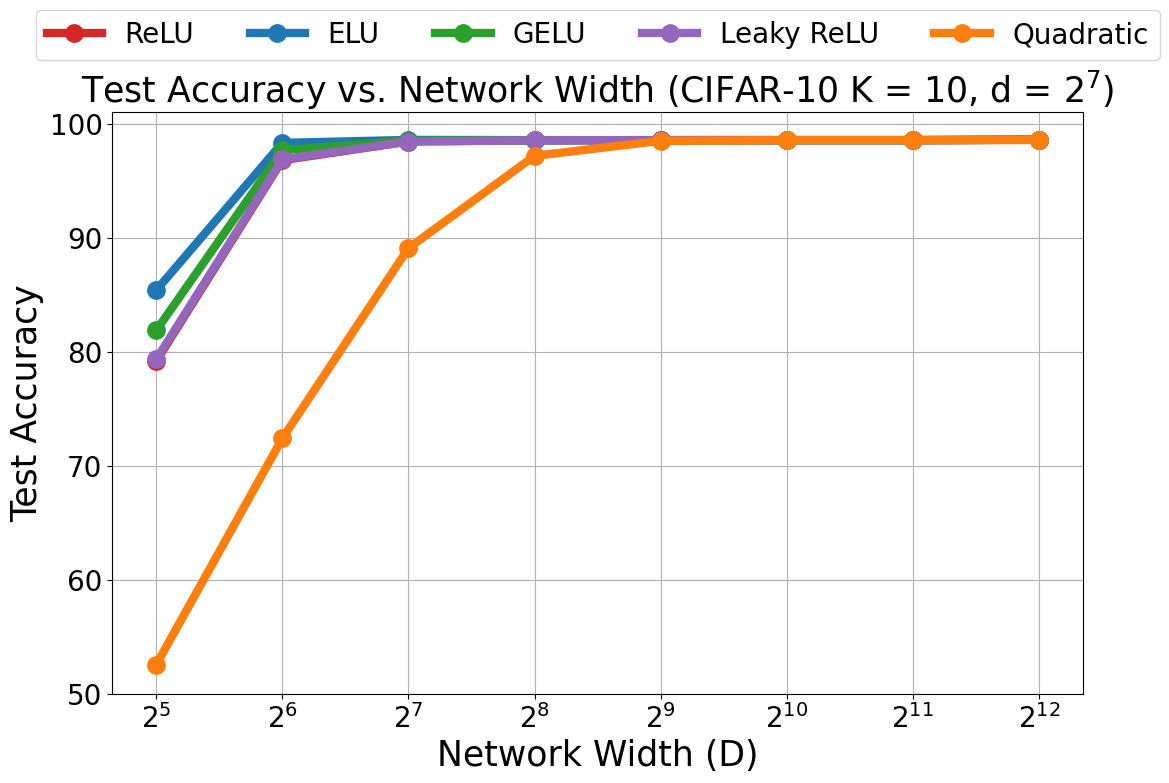

In [49]:
# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))

start_idx = 1
lw = 6
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange'] 
ax1.set_xlabel(r'Network Width (D)', fontsize=25)
ax1.set_ylabel('Test Accuracy', fontsize=25)
ax1.set_title('Test Accuracy vs. Network Width (CIFAR-10 K = ' + str(K) + ', d = $2^7$)', fontsize=25)

lns = []
for i in range(len(colors)):
    l_i = ax1.plot(widths, list(test_accs_act[:, i]), color=colors[i], linewidth=lw, marker=".", markersize=25,
                  label=activations_save[activations[i]])
    lns += l_i

ax1.set_xscale('log', base=2)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
#lns = l2+l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), fontsize=20, ncol=5)
plt.grid()
ax1.set_ylim(50, 101)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()

plt.savefig('./figures/cifar10/cifar10_' + str(K) + '_classes_test.png')